## Описание проекта

На основе исторических данных о заказах такси в аэропортах нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для прогноза.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Последовательность выполнения проекта

1. Загрузка данных и их ресемплирования по часу.
2. Анализ данных.
3. Обучение разных моделей с различными гиперпараметрами.
4. Проверка данных на тестовой выборке (10% от исходной).

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*'.

# 1. Подготовка

In [56]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [57]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [58]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


В таблице 26 000 объектов. Даные представлены за пол-года (с марта 2018 по август 2018) с шагом 10 минут.

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим упорядоченность индексов.

In [60]:
df.index.is_monotonic 

True

In [61]:
df['rolling_mean'] = df['num_orders'].rolling(12).mean()

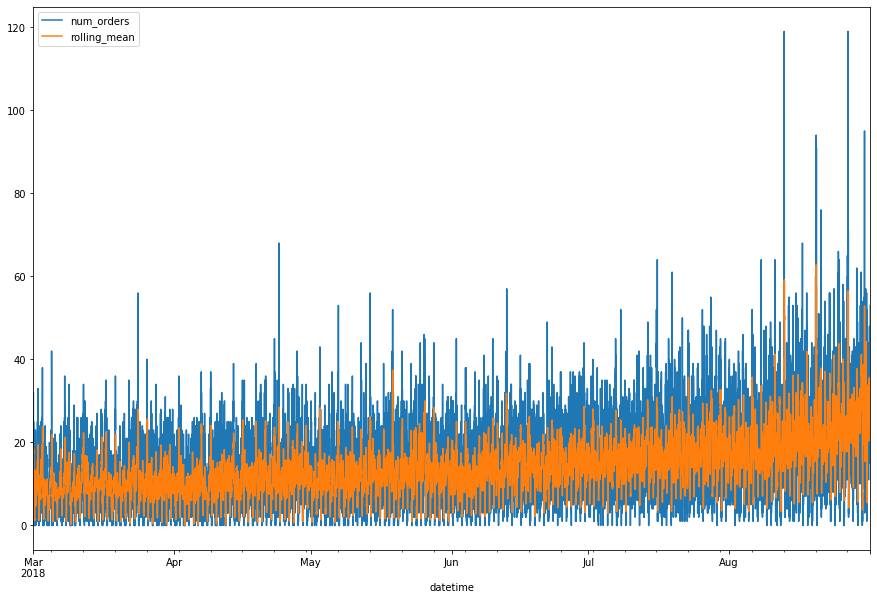

In [62]:
df.plot(figsize=(15,10));

Уменьшим шаг до одного часа.

In [63]:
#df = df.resample('1H').mean()
df = df.resample('1H').sum()

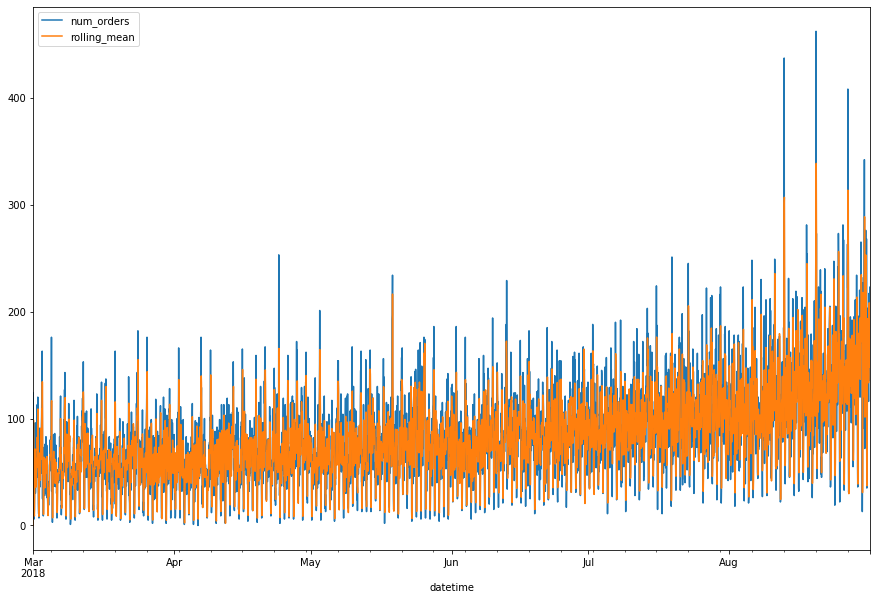

In [64]:
df.plot(figsize=(15,10))

В таблице осталось 4,5 тыс. объектов. При этом, в признаке num_orders вследствие вычисления среднего значения приведены к типу float. Приведем его снова к int.

In [65]:
df['num_orders'] = df['num_orders'].astype(int)

In [66]:
df['rolling_mean'] = df['num_orders'].rolling(12).mean()

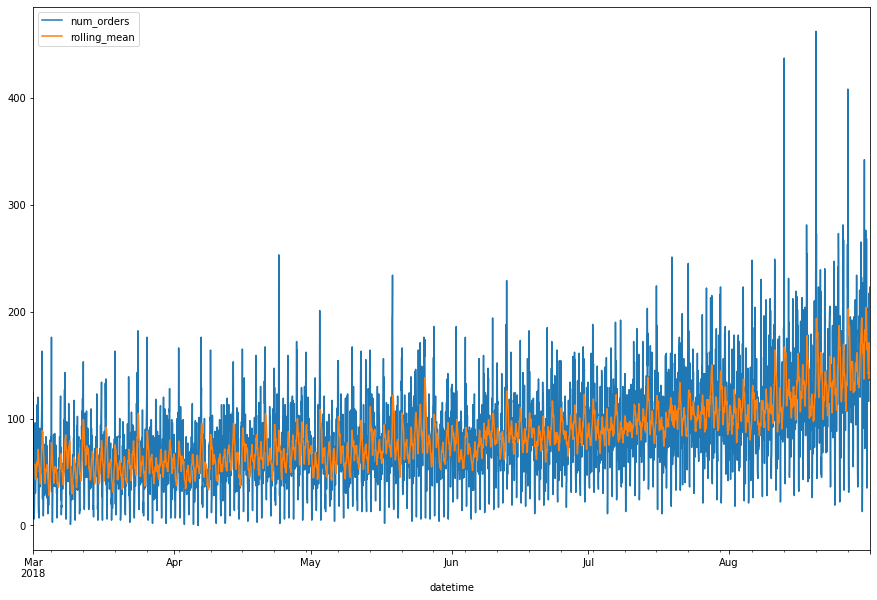

In [67]:
df.plot(figsize=(15,10));

# 2. Анализ

Разобьем наш ряд на составляющие.

In [68]:
decomposed = seasonal_decompose(df['num_orders'])
dec = pd.DataFrame(index=df.index)

In [69]:
dec['trend'] = decomposed.trend
dec['seasonal'] = decomposed.seasonal
dec['residuals'] = decomposed.resid
dec['num_orders'] = df.num_orders
dec['proverka'] =  dec['num_orders'] - decomposed.trend - decomposed.seasonal - decomposed.resid

In [70]:
dec.head()

,trend,seasonal,residuals,num_orders,proverka
datetime,,,,,
2018-03-01 00:00:00,NaN,60.248112,NaN,124,NaN
2018-03-01 01:00:00,NaN,20.177074,NaN,85,NaN
2018-03-01 02:00:00,NaN,28.982743,NaN,71,NaN
2018-03-01 03:00:00,NaN,17.885407,NaN,66,NaN
2018-03-01 04:00:00,NaN,2.791145,NaN,43,NaN


In [71]:
decomposed = seasonal_decompose(df['num_orders'])

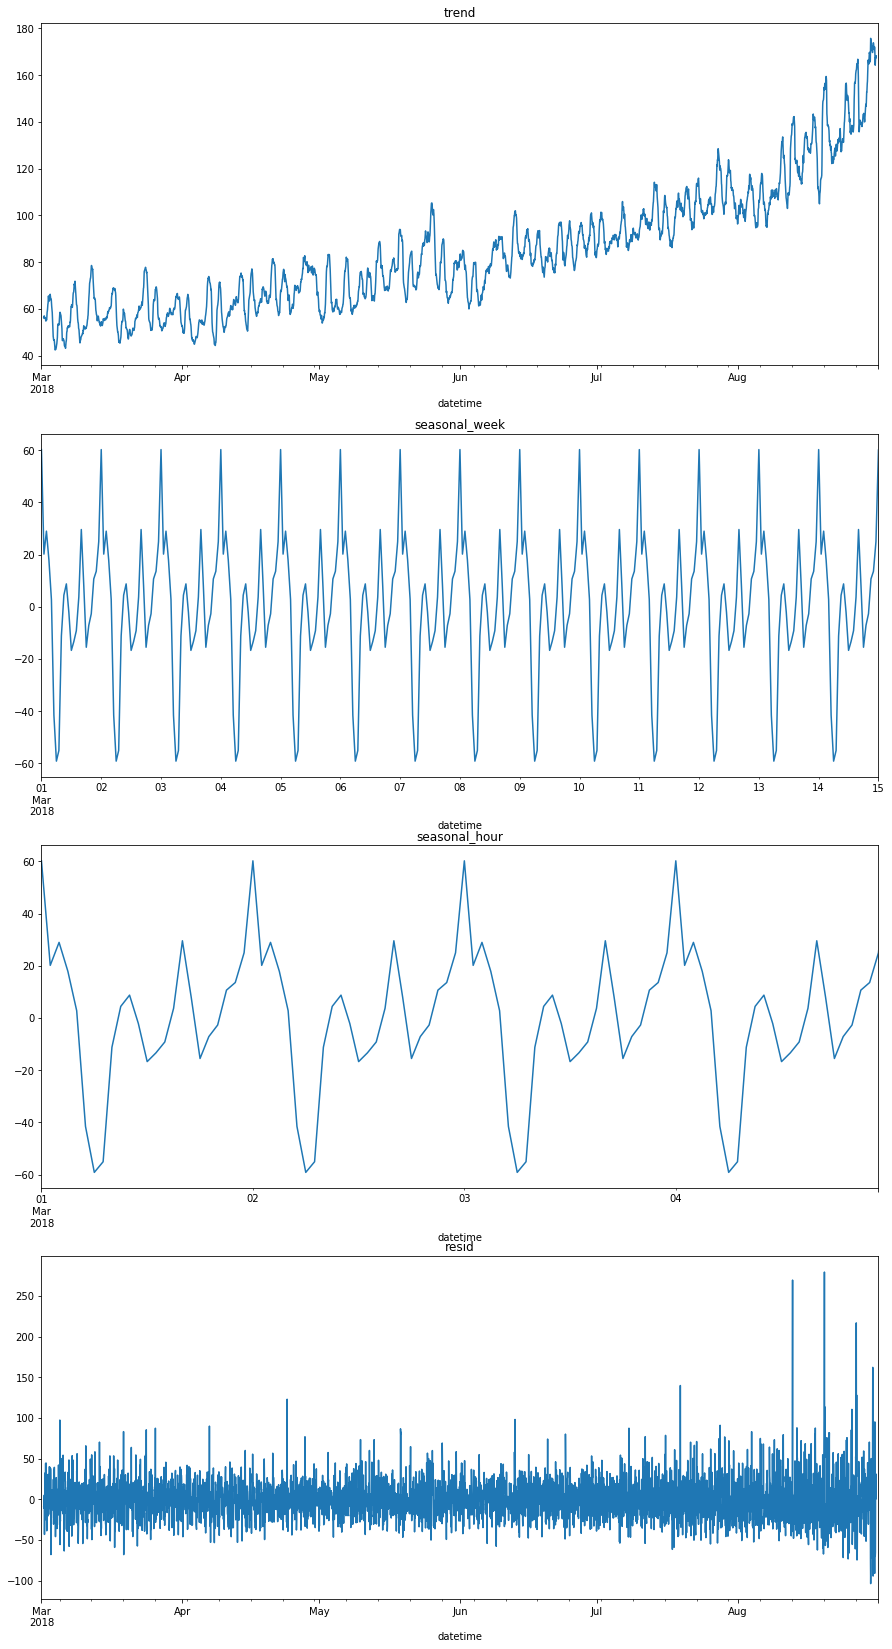

In [72]:
plt.figure(figsize=(15,29))

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('trend')

plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca(), xlim=('2018-03-01', '2018-03-15'))
plt.title('seasonal_week')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca(), xlim=('2018-03-01 00:00', '2018-03-04 23:59'))
plt.title('seasonal_hour')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('resid');

1. С марта по август наблюдается тренд на рост заказов такси на 60%.
2. Наблюдаются суточные колебания с минимумом заказов около 6 утра и максимумом около полуночи. Колебания между днями недели отсутствуют.
3. В среднем шум состаляет +-25 заказов.
4. В конце датасета есть аномально высокие значения шумов. Скорее всего предсказать такие значения наша будущая модель не сможет. 

Создадим новые признаки из имеющихся. Наша задача предсказать количество заказов на следующий час. Поэтому, для создания новых признаков будем брать 2 - 3 из последних известных значений.

**Скользящее максимальных значений количества заказов.**

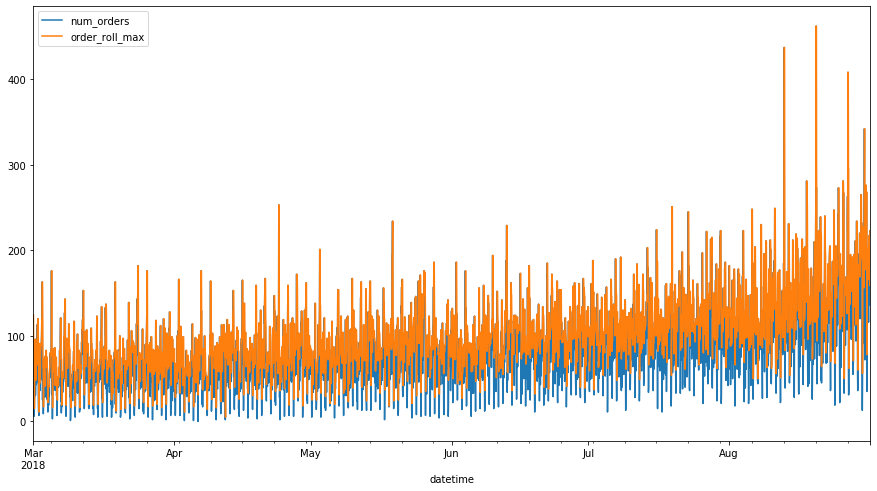

In [73]:
df['order_roll_max'] = df['num_orders'].rolling(3).max()
df[['num_orders', 'order_roll_max']].plot(figsize=(15,8))

**Скользящее минимальное количество заказов**

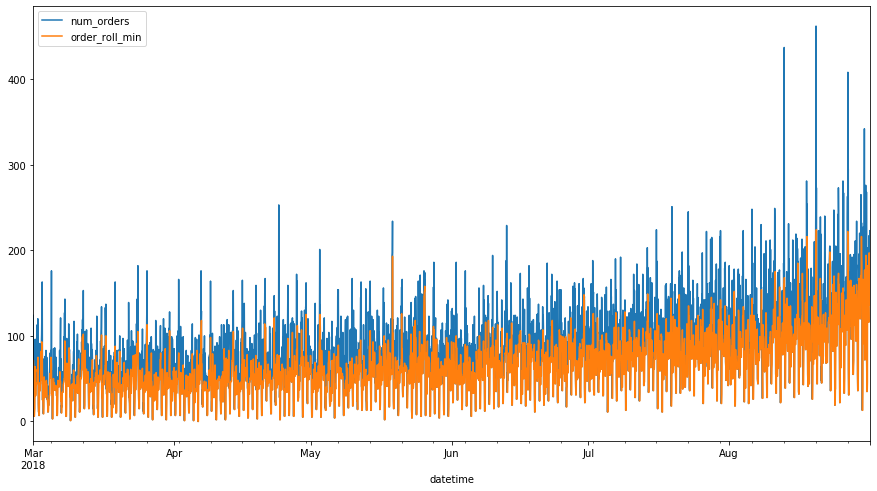

In [74]:
df['order_roll_min'] = df['num_orders'].rolling(3).min()
df[['num_orders', 'order_roll_min']].plot(figsize=(15,8))

Выбранные признаки хорошо отражают локальные максимумы и минимумы.

**Скользящее среднее значение количества заказов**

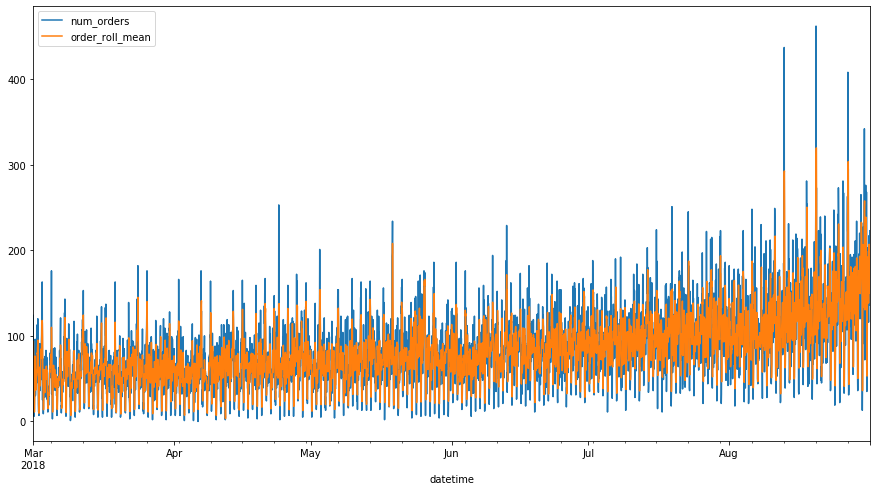

In [75]:
df['order_roll_mean'] = df['num_orders'].rolling(3).mean()
df[['num_orders', 'order_roll_mean']].plot(figsize=(15,8))

**Скользящее среднее тренда**

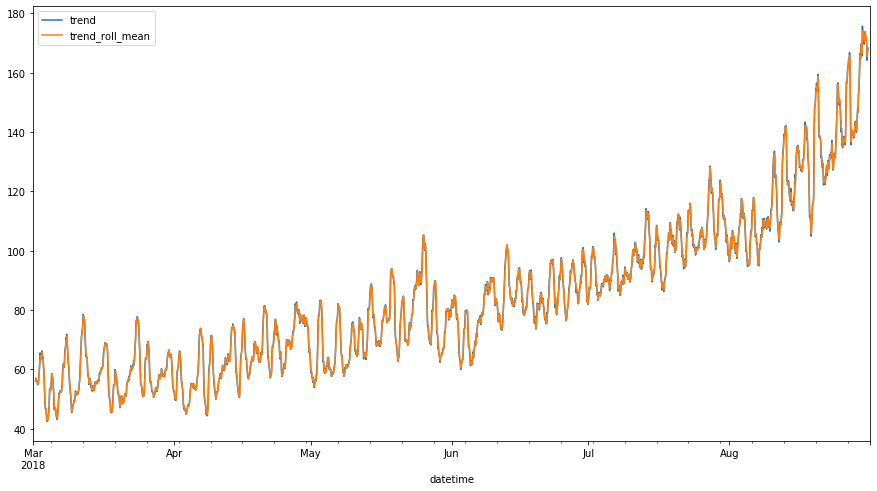

In [76]:
df['trend'] = decomposed.trend
df['trend_roll_mean'] = df['trend'].rolling(3).mean()
df[['trend', 'trend_roll_mean']].plot(figsize=(15,8))

**Скользящее максимального значения тренда**

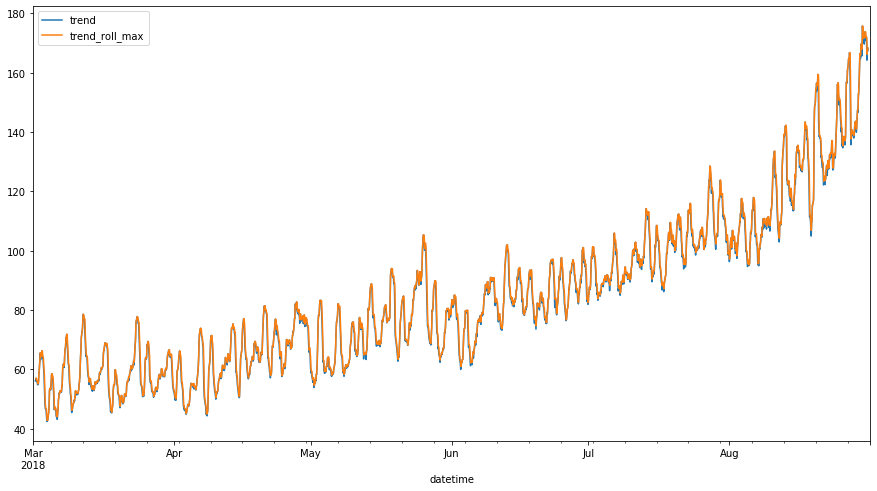

In [77]:
df['trend_roll_max'] = df['trend'].rolling(3).max()
df[['trend', 'trend_roll_max']].plot(figsize=(15,8))

**Скользящее минимальное значения тренда**

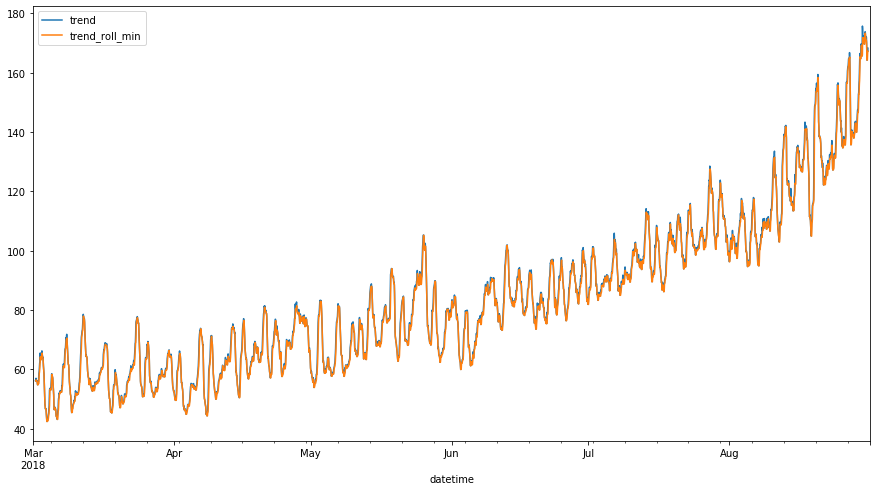

In [78]:
df['trend_roll_min'] = df['trend'].rolling(3).min()
df[['trend', 'trend_roll_min']].plot(figsize=(15,8))

**Скользящее среднее сезонной составляющей ряда**

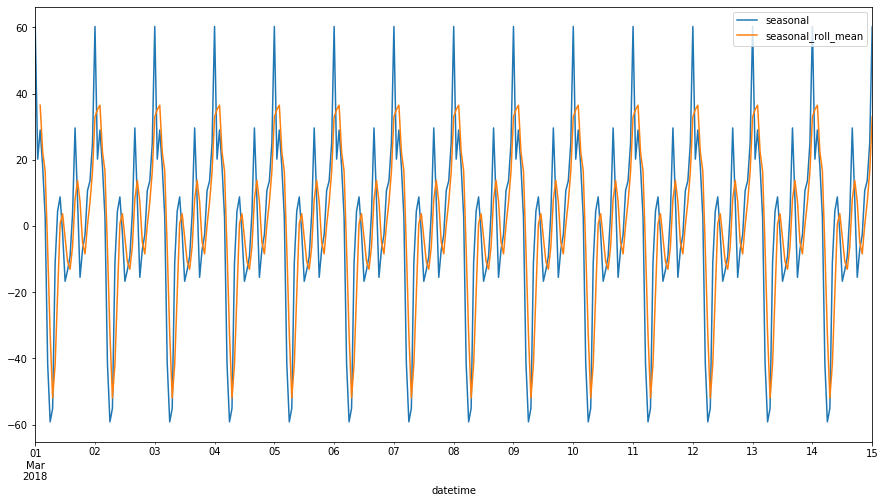

In [79]:
df['seasonal'] = decomposed.seasonal
df['seasonal_roll_mean'] = df['seasonal'].rolling(3).mean()
df[['seasonal', 'seasonal_roll_mean']].plot(figsize=(15,8), xlim=('2018-03-01', '2018-03-15'))

Полученные значения плохо описывают экстремумы сезонной составляющей. Поэтому сделаем также скользящие максимальных и минимальных значений.

**Скользящее максимальное сезонной составляющей ряда**

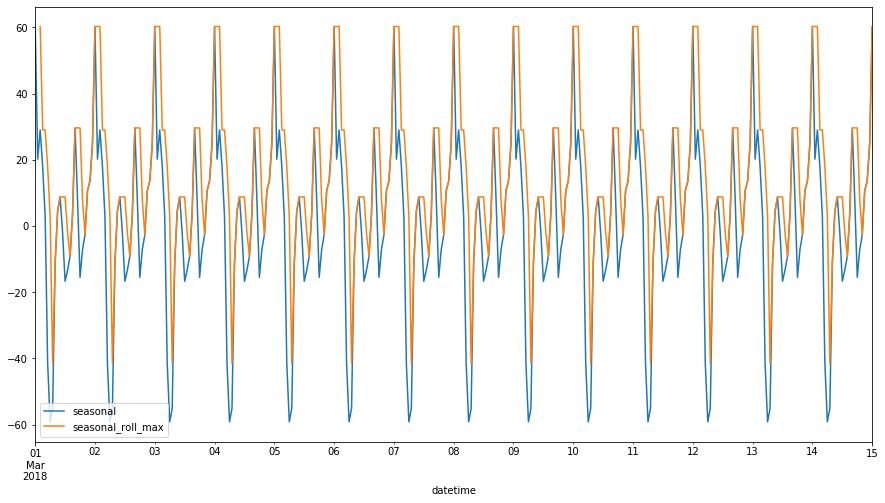

In [80]:
df['seasonal_roll_max'] = df['seasonal'].rolling(3).max()
df[['seasonal', 'seasonal_roll_max']].plot(figsize=(15,8), xlim=('2018-03-01', '2018-03-15'))

**Скользящее минимальное сезонной составляющей ряда**

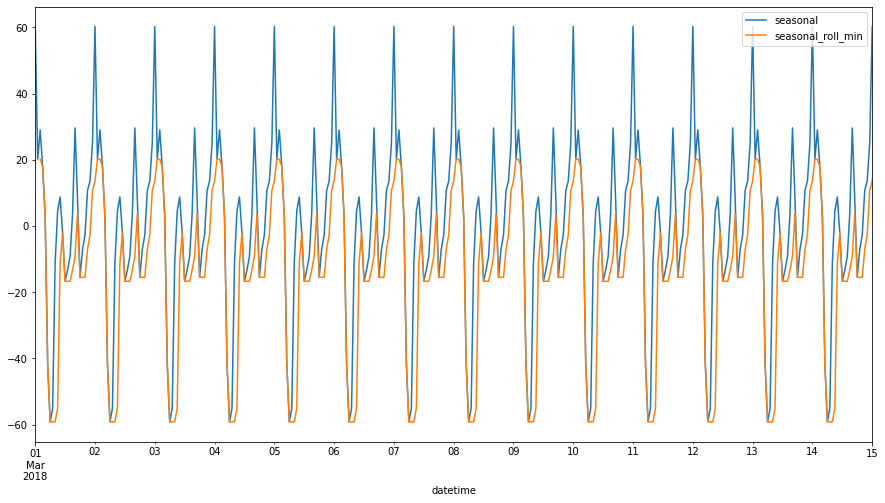

In [81]:
df['seasonal_roll_min'] = df['seasonal'].rolling(3).min()
df[['seasonal', 'seasonal_roll_min']].plot(figsize=(15,8), xlim=('2018-03-01', '2018-03-15'))

Добавим к признакам месяц (для прогнозирования тренда), дни (для целостности признаков) и часы (для прогнозирования сезонности).

In [85]:
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

In [86]:
df.head()

,num_orders,rolling_mean,order_roll_max,order_roll_min,order_roll_mean,trend,trend_roll_mean,trend_roll_max,trend_roll_min,seasonal,seasonal_roll_mean,seasonal_roll_max,seasonal_roll_min,resid,resid_roll_mean,resid_roll_min,resid_roll_max,month,day,hour
datetime,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.248112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,0
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.177074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,1
2018-03-01 02:00:00,71,NaN,124.0,71.0,93.333333,NaN,NaN,NaN,NaN,28.982743,36.469310,60.248112,20.177074,NaN,NaN,NaN,NaN,3,1,2
2018-03-01 03:00:00,66,NaN,85.0,66.0,74.000000,NaN,NaN,NaN,NaN,17.885407,22.348408,28.982743,17.885407,NaN,NaN,NaN,NaN,3,1,3
2018-03-01 04:00:00,43,NaN,71.0,43.0,60.000000,NaN,NaN,NaN,NaN,2.791145,16.553098,28.982743,2.791145,NaN,NaN,NaN,NaN,3,1,4


И добавим прошлые значения количества заказов. Если нам нужно предсказать на один час вперед - значит мы можем брать второе последнее значение.

In [87]:
df['order_shift_2'] = df['num_orders'].shift(2)
df['order_shift_3'] = df['num_orders'].shift(3)
df['order_shift_4'] = df['num_orders'].shift(4)

In [88]:
df.head(3)

,num_orders,rolling_mean,order_roll_max,order_roll_min,order_roll_mean,trend,trend_roll_mean,trend_roll_max,trend_roll_min,seasonal,...,resid,resid_roll_mean,resid_roll_min,resid_roll_max,month,day,hour,order_shift_2,order_shift_3,order_shift_4
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.248112,...,NaN,NaN,NaN,NaN,3,1,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.177074,...,NaN,NaN,NaN,NaN,3,1,1,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,124.0,71.0,93.333333,NaN,NaN,NaN,NaN,28.982743,...,NaN,NaN,NaN,NaN,3,1,2,124.0,NaN,NaN


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 23 columns):
num_orders            4416 non-null int64
rolling_mean          4405 non-null float64
order_roll_max        4414 non-null float64
order_roll_min        4414 non-null float64
order_roll_mean       4414 non-null float64
trend                 4392 non-null float64
trend_roll_mean       4390 non-null float64
trend_roll_max        4390 non-null float64
trend_roll_min        4390 non-null float64
seasonal              4416 non-null float64
seasonal_roll_mean    4414 non-null float64
seasonal_roll_max     4414 non-null float64
seasonal_roll_min     4414 non-null float64
resid                 4392 non-null float64
resid_roll_mean       4390 non-null float64
resid_roll_min        4390 non-null float64
resid_roll_max        4390 non-null float64
month                 4416 non-null int64
day                   4416 non-null int64
hour               

Удалим получившиеся пропущенные значения.

In [90]:
df = df.dropna()

# 3. Обучение

Разделим выборку на тестовую и обучающую в соотношении 9:1:

In [91]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [92]:
test.shape

(439, 23)

Подготовим таблицы признаков:

In [93]:
features_columns = [
'month',
'day',
'hour',
'order_shift_2',
'order_shift_3',
'order_shift_4',
'order_roll_mean',
'order_roll_min',
'order_roll_max',
]

features_train = train[features_columns]
target_train = train[['num_orders']]

features_test = test[features_columns]
target_test = test[['num_orders']]

Для наглядности выведем средние значения RMSE всех моделей для каждого состава обучающих признаков.

Ниже представлено сравнение точности моделей в зависимости от состава обучающих признаков. Столбцы - это набор обучающих признаков. В первом столбце берем только показатели даты (месяц, день, час), затем добавляем shift(2), потом еще shift(3) и shift(4) (что дало небольшую прибавку качества - в среднем на 1%).
    
Из таблицы видно, что наилучший прирост качества моделей (около 30%) получен после добавления в признаки скользящего среднего количества заказов (order_roll_mean). Добавление скользящих макимального и минимального количества заказов улучшило качество моделей в среднем на 5%.
    
Добавление в признаки трендовой, сезонной и шумовой составляющей проводится для каждой составляющей независимо друг от друга (к признакам '+order_roll_min, max' добавляются скользящие средние, максимальные и минимальные только одной составляющей (тренда, сезонной или остатков)). 

В правых двух столбцах таблицы приводятся RMSE для моделей, в обучающую выборку которых включены 1) составляющие временного ряда, которые показали положительный прирост качества 2) все признаки.

In [94]:
columns_compare = ['model',
                   'date',
                   '+shift_2',
                   '+shift_4',
                   '+order roll mean',
                   '+order roll min, max',
                   '+trend mean',
                   '+trend min, max',
                   '+seasonal mean',
                   '+seasonal min, max',
                   '+resid mean',
                   '+resid min, max',
                   '+trend mean, +seasonal all',
                   '+trend all, seasonal all',
                   '+trend all + seasonal all, +resid all'
                   
                   ]
data_compare = [['LinearRegression', 43.43, 42.59, 42.34, 22.25, 22.15, 22.11, 22.11, 22.32, 21.98, 22.37, 22.36, 21.94, 21.95, 21.96],
                ['RandomForest', 29.37, 28.64, 28.33, 20.48, 19.09, 19.17, 19.22, 19.12, 19.07, 19.24, 19.37, 19.18, 19.18, 19.36],
                ['CatBoost', 34.13, 33.83, 33.81, 26.07, 25.07, 24.73, 24.86, 24.83, 24.79, 25.39, 25.98, 24.98, 24.62, 25.46],
                ['LightGBM', 28.62, 28.06, 27.40, 18.94, 17.56, 17.66, 17.66, 17.20, 17.12, 17.58, 17.58, 17.20, 17.24, 16.99],
                ['XGBoost', 28.50, 27.75, 27.35, 18.89, 17.45, 17.76, 17.75, 17.58, 17.38, 17.78, 17.62, 17.52, 17.73, 17.56]]
compare_features = pd.DataFrame(data=data_compare, columns=columns_compare)
compare_features

,model,date,+shift_2,+shift_4,+order roll mean,"+order roll min, max",+trend mean,"+trend min, max",+seasonal mean,"+seasonal min, max",+resid mean,"+resid min, max","+trend mean, +seasonal all","+trend all, seasonal all","+trend all + seasonal all, +resid all"
0,LinearRegression,43.43,42.59,42.34,22.25,22.15,22.11,22.11,22.32,21.98,22.37,22.36,21.94,21.95,21.96
1,RandomForest,29.37,28.64,28.33,20.48,19.09,19.17,19.22,19.12,19.07,19.24,19.37,19.18,19.18,19.36
2,CatBoost,34.13,33.83,33.81,26.07,25.07,24.73,24.86,24.83,24.79,25.39,25.98,24.98,24.62,25.46
3,LightGBM,28.62,28.06,27.40,18.94,17.56,17.66,17.66,17.20,17.12,17.58,17.58,17.20,17.24,16.99
4,XGBoost,28.50,27.75,27.35,18.89,17.45,17.76,17.75,17.58,17.38,17.78,17.62,17.52,17.73,17.56


Результаты тестов показывают, что наибольшее влияние оказало скользящее среднее количества заказов. Добавление в признаки различных составляющих временного ряда (трендовой, сезонной) по отдельности не оказывает существенное влияние на модели. Добавление в признаки шумов (остатков) негативно отражается на качестве модели.

Обучим разные модели и вычислим RMSE для валидационной выборки.

**Линейная регрессия**

Для моделей регрессии разобьем обучающую выборку на обучающую и валидационную. В дальнейшем будем использовать GridSearchCV и его встроенную кросс-валидацию на features_train и target_train.

In [95]:
(features_train_train,
 features_valid,
 target_train_train,
 target_valid) = train_test_split(features_train, target_train, test_size=0.2, shuffle=False)

Обучим и протестируем модель. И заодно начнем создавать результирующую таблицу.

In [96]:
model_lrr = LinearRegression()
model_lrr.fit(features_train_train, target_train_train)
score_lrr = mean_squared_error(model_lrr.predict(features_valid), target_valid) ** 0.5
print('RMSE: {:.2f}'.format(score_lrr))

RMSE: 22.15


В остальных моделях подберем параметры с использованием GridSearchCV. Поскольку мы имеем дело с временными рядами, необходимо создать объект TimeSeriesSplit для корректной кросс-валидации.

In [97]:
tscv = TimeSeriesSplit()

In [98]:
tscv.split(features_train)

<generator object TimeSeriesSplit.split at 0x7f387892bcd0>

Для подбора параметров напишем функцию для подбора гиперпараметров модели. Она принимает на вход необученную модель и словарь гиперпараметров, выводит на экран лучшие параметры, МАЕ и возвращает модель, обученную на полной выборке.

In [99]:
def search_best_params(model, params):
    
    model=model
    
    gridsv = GridSearchCV(param_grid=params,
                          estimator=model,
                          scoring='neg_mean_squared_error',
                          cv=tscv,
                          refit=True)
    
    gridsv.fit(features_train, target_train)
    
    print('Лучшие параметры: {}'.format(gridsv.best_params_))
    print('RMSE: {:.2f}'.format(abs(gridsv.best_score_) ** 0.5))
    
    return gridsv

**Случайный лес:**

In [100]:
%%time
model_rfr = RandomForestRegressor(random_state=12)

params_rfr = {'max_depth' : [2,5,7,10,15,20],
              'min_samples_split' : [2, 10, 50, 100, 150],
              'min_samples_leaf' : [1, 10, 50, 100, 150]}

model_rfr = search_best_params(model_rfr, params_rfr)

Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}
RMSE: 19.09
CPU times: user 22.4 s, sys: 104 ms, total: 22.5 s
Wall time: 22.5 s


**Catboost**

In [101]:
%%time
model_cb = cb.CatBoostRegressor(random_state=12, verbose=1000, num_boost_round=50, leaf_estimation_iterations=1)

params_cb = {'depth' : [4, 6, 8, 10]}

model_cb = search_best_params(model_cb, params_cb)

0:	learn: 28.7996544	total: 924us	remaining: 45.3ms
49:	learn: 17.1007922	total: 213ms	remaining: 0us
0:	learn: 31.3392362	total: 2.92ms	remaining: 143ms
49:	learn: 18.7435273	total: 307ms	remaining: 0us
0:	learn: 33.3384762	total: 81.7ms	remaining: 4s
49:	learn: 19.6011651	total: 520ms	remaining: 0us
0:	learn: 28.7327262	total: 1.43ms	remaining: 69.9ms
49:	learn: 16.2039014	total: 301ms	remaining: 0us
0:	learn: 31.3140033	total: 90.5ms	remaining: 4.43s
49:	learn: 17.6274145	total: 840ms	remaining: 0us
0:	learn: 33.3095904	total: 59.9ms	remaining: 2.93s
49:	learn: 18.2608934	total: 788ms	remaining: 0us
0:	learn: 28.7076153	total: 101ms	remaining: 4.94s
49:	learn: 15.7306480	total: 747ms	remaining: 0us
0:	learn: 31.3332966	total: 10ms	remaining: 492ms
49:	learn: 17.0910741	total: 945ms	remaining: 0us
0:	learn: 33.2977621	total: 3.79ms	remaining: 186ms
49:	learn: 17.6049308	total: 1.19s	remaining: 0us
0:	learn: 28.7131953	total: 76.5ms	remaining: 3.75s
49:	learn: 15.3872672	total: 1.71s	

**LightGBM**

In [102]:
%%time

model_lgb = lgb.LGBMRegressor(random_state=12)

params_lgb = {'max_depth' : [5, 7, 10, 15],
              'num_leaves' : [10, 20, 50, 80, 120],
              'min_data_in_leaf' : [10, 50, 100, 1000]}

model_lgb = search_best_params(model_lgb, params_lgb)

Лучшие параметры: {'max_depth': 5, 'min_data_in_leaf': 10, 'num_leaves': 20}
RMSE: 17.56
CPU times: user 18.3 s, sys: 844 ms, total: 19.1 s
Wall time: 19.1 s


**XG boost**

In [103]:
%%time
model_xgb = xgb.XGBRegressor(random_state=12, verbosity=0)

params_xgb = {'max_depth' : [5, 7, 10, 15],
              'min_child_weight' : [1, 2, 5, 10, 15, 20]}

model_xgb = search_best_params(model_xgb, params_xgb)

Лучшие параметры: {'max_depth': 5, 'min_child_weight': 5}
RMSE: 17.45
CPU times: user 28.3 s, sys: 300 ms, total: 28.6 s
Wall time: 28.6 s


Для оценки построенных моделей помсотрим что покажут модели, предсказывающие медианное значение для всех покаателей и модель, предлсказывающее предыдущее значение целевого признака.

Медианная модель

In [104]:
pred_median = np.ones(target_test.shape) * target_train.median().values
mean_squared_error(pred_median, target_test) ** 0.5

86.05508909941867

Предсказание предыдущим значением

In [105]:
pred_previos = target_valid.shift()
pred_previos.iloc[0] = target_train.iloc[-1]
mean_squared_error(pred_previos, target_valid)

2109.860935524652

Сведем результаты в таблицу.

In [106]:
columns = ['model', 'rmse']
data = [['LinearRegression', 22.15],
        ['RandomForest', 19.09],
        ['CatBoost', 25.07],
        ['LightGBM', 17.56],
        ['XGBoost', 17.45]]
compare_models = pd.DataFrame(data=data, columns=columns)
compare_models.sort_values(by='rmse')

,model,rmse
4,XGBoost,17.45
3,LightGBM,17.56
1,RandomForest,19.09
0,LinearRegression,22.15
2,CatBoost,25.07


Лучшую RMSE показала модель XG Boost. Протестируем ее.

# 4. Тестирование

Определим RMSE на тестовой выборке для модели  XG Boost. 

In [107]:
rmse = mean_squared_error(model_xgb.predict(features_test), target_test) ** 0.5
print('RMSE = {:.2f}'.format(rmse))

RMSE = 31.48


Построим график сравнения целевого признака и наших предсказаний.

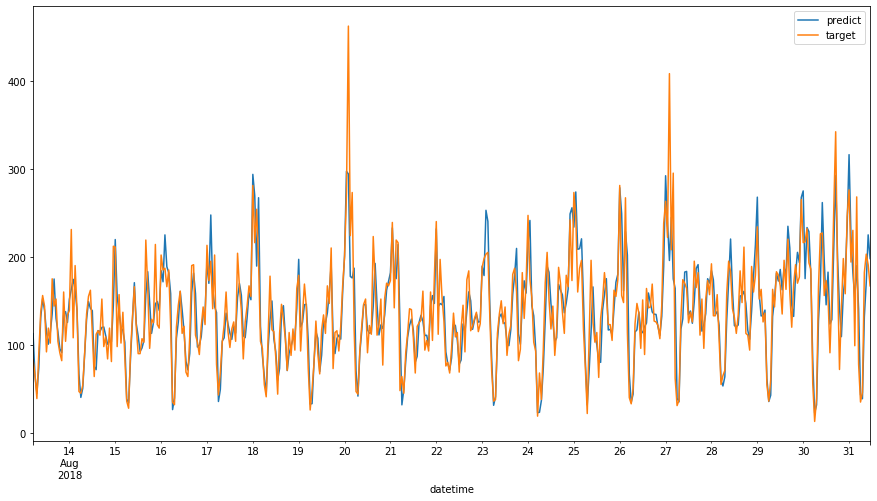

In [108]:
result = pd.DataFrame(index=target_test.index, columns=['predict', 'target'])
result['predict'] = model_xgb.predict(features_test)
result['target'] = target_test
result.plot(figsize=(15,8));

Предсказания хорошо ложаться на ответы тестовой выборки за исключением трех максимальных пиков.

# Выводы:

1. Проведен анализ временного ряда. Выделены составляющие тренда, сезонности и шума.
2. На основе количества заказов на определнный час подготовлены признаки, отражающие предыдущие значения, максимальные и минимальные значения.
3. Обучено несколько моделей. Наилучший результат на кросс-валидации показал XG Boost c RMSE=17.45.
4. На тестовой выборке модель показала RMSE=31.48.